In [1]:
# General Imports
import re
import zipfile 
from tqdm.notebook import tqdm
from emoji import demojize
from typing import Union, List
import concurrent.futures

# Data Analysis and visualizations
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# Import Spacy
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS as stop_words  # Import default English stop words

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Import NLTK
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
nltk.download('punkt', quiet=True)
nltk.download('sentiwordnet')
nltk.download('wordnet')

2024-04-03 12:53:52.963577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 12:53:52.963670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 12:53:53.048520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 12:53:53.224604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 12:53:54.576409: W tensorflow/compiler/tf2

True

In [2]:
# verify working directory of the notebook 
import os 
print(os.getcwd())
import sys
path = os.path.abspath(os.path.join('../../')) # or the path to your source code
sys.path.insert(0, path)
print(path)

/home/jon/Documents/HEC/HEC/Session 4 Winter 2024/Machine Learning I/Project/WallstreetbetsGenNLP/tests/jonathan
/home/jon/Documents/HEC/HEC/Session 4 Winter 2024/Machine Learning I/Project/WallstreetbetsGenNLP


In [3]:
# Extract the zip files

# Specify the path to the zip file
zip_file_path = path + '/data_raw/reddit_wsb.csv.zip'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('data_raw')

# Read the CSV using Pandas
csv_file_path = 'data_raw/reddit_wsb.csv'
df = pd.read_csv(csv_file_path)

In [4]:
# Preprocessing functions

def preprocess_text(texts: Union[str, List[str], pd.Series], clean_emojis: bool = False) -> Union[str, List[str]]:
    cleaned_texts = []

    # Processing texts using Spacy pipeline
    for doc in tqdm(nlp.pipe(texts, batch_size=20), total=len(texts), desc="Cleaning Texts"):

        # Handle emojis: translate to text if not removing, else remove
        if clean_emojis:
            doc = re.sub(r':[^:]+:', '', demojize(doc.text))  # Remove emojis
        else:
            doc = demojize(doc.text)  # Convert emojis to text

        # Tokenization and preprocessing
        tokens = [token.text.lower() for token in nlp(doc) if token.text.isalpha()]

        # Removing stopwords and short tokens
        tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

        cleaned_texts.append(' '.join(tokens))  # Rejoin tokens into a string

    return cleaned_texts


In [5]:
# Fill all the NaN values in the body column with an empty string
df['body'] = df['body'].fillna('')

# Combine the title and bodyy into a single column text, separated by two newlines
df['text'] = df['title'] + '\n\n' + df['body']

# drop the body column 
df = df.drop(columns=['body'])

# Preview the loaded data 
display(df.head(10))


,title,score,id,url,comms_num,created,timestamp,text
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,2021-01-28 21:37:41,"It's not about the money, it's about sending a..."
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,2021-01-28 21:30:35,Exit the system\n\nThe CEO of NASDAQ pushed to...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC..."
5,WE BREAKING THROUGH,405,l6uf7d,https://i.redd.it/2wef8tc062e61.png,84,1.611862e+09,2021-01-28 21:26:30,WE BREAKING THROUGH\n\n
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,2021-01-28 21:26:27,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE\n\...
7,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,2021-01-28 21:19:31,THIS IS THE MOMENT\n\nLife isn't fair. My moth...
8,Currently Holding AMC and NOK - Is it retarded...,200,l6ub4i,https://i.redd.it/6k2z7ouo42e61.png,161,1.611862e+09,2021-01-28 21:19:16,Currently Holding AMC and NOK - Is it retarded...
9,I have nothing to say but BRUH I am speechless...,291,l6uas9,https://i.redd.it/bfzzw2yo42e61.jpg,27,1.611862e+09,2021-01-28 21:18:37,I have nothing to say but BRUH I am speechless...


In [13]:
texts = pd.DataFrame(df['text'])

In [9]:
# Preprocess each title and track progress with tqdm
texts['processed_text'] = preprocess_text(texts['text'], clean_emojis=True)


Cleaning Texts:   0%|          | 0/53187 [00:00<?, ?it/s]

In [10]:


import nltk
from concurrent.futures import ThreadPoolExecutor
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text_row):
    idx, text = text_row  # Unpack the tuple received
    score = sia.polarity_scores(text)['compound']  # Compute the compound score
    # Determine the sentiment label based on the compound score
    if score >= 0.05:
        label = 'positive'
    elif score <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return idx, (score, label)

def process_with_vader(dataframe):
    # Extract (index, text) tuples for parallel processing
    texts_to_analyze = list(dataframe['processed_text'].items())
    
    num_cores = os.cpu_count()
    max_workers = num_cores - 1  # Adjust based on your machine
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Execute analysis in parallel
        results = list(executor.map(analyze_sentiment_vader, texts_to_analyze))
    
    # Convert results into two dictionaries {index: sentiment_score} and {index: sentiment_label}
    scores = {idx: result[0] for idx, result in results}
    labels = {idx: result[1] for idx, result in results}
    
    # Map the scores and labels back to the DataFrame using the index
    dataframe['sentiment_score'] = dataframe.index.map(scores)
    dataframe['sentiment_label'] = dataframe.index.map(labels)
    return dataframe


# Process texts with VADER to update DataFrame with sentiment scores and labels
texts_with_sentiment = process_with_vader(texts)

# Display the updated DataFrame
display(texts.head(50))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text,processed_text,sentiment_score,sentiment_label
0,"It's not about the money, it's about sending a...",money sending message,0.0000,neutral
1,Math Professor Scott Steiner says the numbers ...,math professor scott steiner says numbers spel...,-0.6249,negative
2,Exit the system\n\nThe CEO of NASDAQ pushed to...,exit system ceo nasdaq pushed halt trading giv...,0.3612,positive
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,new sec filing gme someone less retarded pleas...,-0.3368,negative
4,"Not to distract from GME, just thought our AMC...",distract gme thought amc brothers aware,-0.2960,negative
5,WE BREAKING THROUGH\n\n,breaking,0.0000,neutral
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE\n\...,short stock expiration date hedgefund whales s...,-0.7506,negative
7,THIS IS THE MOMENT\n\nLife isn't fair. My moth...,moment life fair mother always told would comp...,-0.9719,negative
8,Currently Holding AMC and NOK - Is it retarded...,currently holding amc nok retarded think move ...,-0.5719,negative
9,I have nothing to say but BRUH I am speechless...,nothing say bruh speechless moon,0.0000,neutral


<Axes: >

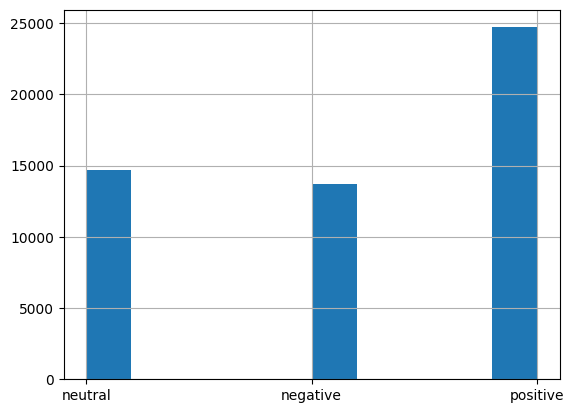

In [11]:
texts['sentiment_label'].hist()